<center><h1>AMAZON ALEXA REVIEW CLASSIFICATION MODEL </h1><center>

<h3> Contents </h3><br>

<b>Introduction</b><br>

<b>1.Import libraries</b><br>
<b>2. Data analysis</b><br>
<b>3. Data preprocessing</b><br>
<b>4. Model training</b><br>

<b>Results</b><br>

<center><h2> Introduction </h2></center>

<h3> Goals and Objectives </h3>

The study aims to develop a model which predicts a type of feedback on Amazon Alexa products according to the text of users' reviews. To achieve this goal, a number of objectives were identified, including:<br>
1.Analysis of the existing dataset<br>
2.Determining the type of the model (classification or regression)<br>
3.Engineering of the existing features<br>
4.Creating the best-performance model

<h3> Models and Tools </h3>

During the research the following classification models were used:
    
Decision Tree Classifier<br>
XGBoost Classifier<br>
Random Forest Classifier<br>
KNN Classifier<br>
AdaBoost Classifier<br>
SVC Classifier<br>
Logistic Regression Classifier<br>
Naive Bayes Classifier

<h3> Results </h3>

According to the comparison of train/test accuracy score (difference is less than 3%) and ROC-AUC (above 87%) for test set <b> AdaBoost Classifier </b> was chosen as the best classification model.

<center><h2> 1. Import libraries </h2></center>

In [2]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

#Vectorizer

from sklearn.feature_extraction.text import CountVectorizer

#Classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#GridSearchCV

from sklearn.model_selection import GridSearchCV

In [4]:
#Disable warnings

import warnings
warnings.filterwarnings('ignore')

In [5]:
#Model results list dictionary
model_list = list()
train_accuracy_score_list = list()
test_accuracy_score_list = list()
roc_auc_list = list()

<center><h2> 2. Data analysis </h2><center>

In [6]:
#Upload dataset

df_alexa = pd.read_csv('./amazon_alexa.tsv', sep = '\t')

In [7]:
# Show first 10 rows

df_alexa.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [8]:
#Define variables

print('Current dataset contains: ',len(df_alexa.columns),' variables, including:')
print(list(df_alexa.columns))


Current dataset contains:  5  variables, including:
['rating', 'date', 'variation', 'verified_reviews', 'feedback']


<h4> Definition of variables: </h4><br>
<u> rating </u> - <i> product raiting </i><br>
<u> date </u> - <i> feedback date </i><br>
<u> variation </u> - <i> type of product </i><br>
<u> verified_reviews </u> - <i> feedback text </i><br>
<u> feedback </u> - <i> type of feedback </i><br>

In current project <b> feedback </b> is dependent variable.

The dependent variable contains  2  unique labels: [1 0]
Percentage of "0" labels: 8.16%
Percentage of "1" labels: 91.84%


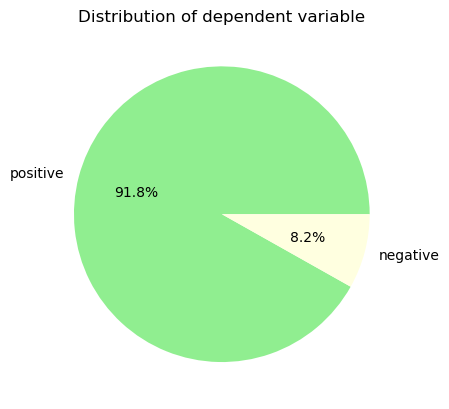

In [9]:
#Analysis of the dependent variable

print('The dependent variable contains ',len(df_alexa['feedback'].unique()),' unique labels:', df_alexa['feedback'].unique())

print('Percentage of "0" labels: {:.2%}'.format(list(df_alexa['feedback']).count(0) / len(df_alexa['feedback'])))
print('Percentage of "1" labels: {:.2%}'.format(list(df_alexa['feedback']).count(1) / len(df_alexa['feedback'])))

feedback = list()
feedback.append(list(df_alexa['feedback']).count(1) / len(df_alexa['feedback']))
feedback.append(list(df_alexa['feedback']).count(0) / len(df_alexa['feedback']))
feedback_labels = ['positive', 'negative']
colors=['lightgreen', 'lightyellow']
plt.pie(feedback, labels = feedback_labels, autopct='%.1f%%', colors = colors)
plt.title('Distribution of dependent variable')
plt.show()

The analysis shows that dependent variable has a binary structure which means that classification model can be used to achieve the goal of the project. However the unequal relation between two labels shows that dataset is not balanced.

In [10]:
# Show general information about dataset 

df_alexa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [11]:
#Types of independent variables


#numerical: discrete & continuous
discrete = [var for var in df_alexa.columns if df_alexa[var].dtype != 'O' and var != 'feedback' and df_alexa[var].nunique() < 10]
continuous = [var for var in df_alexa.columns if df_alexa[var].dtype != 'O' and var !='feedback' and var not in discrete]

#categorical
categorical = [var for var in df_alexa.columns if df_alexa[var].dtype == 'O']

print('Current dataset contains:')
print()
print('    {} numerical variables,'.format(len(discrete) + len(continuous)), 'including:')
print('        {} discrete variables:'.format(len(discrete)), list(df_alexa[discrete].columns))
print('        {} continuous variables:'.format(len(continuous)), list(df_alexa[continuous].columns))
print()
print('    {} categorical variables:'.format(len(categorical)), list(df_alexa[categorical].columns))

Current dataset contains:

    1 numerical variables, including:
        1 discrete variables: ['rating']
        0 continuous variables: []

    3 categorical variables: ['date', 'variation', 'verified_reviews']


In [12]:
# List of variables with missing values

for variable in df_alexa:
    percentage_of_missing_values = df_alexa[variable].isnull().mean()
    if percentage_of_missing_values > 0:
        print(variable, ' = {:.2%}'.format(percentage_of_missing_values))

verified_reviews  = 0.03%


The dataset contains both numerical and categorical variables; only one label in 'verified_revies' variable contains missing data, so it can be dropped without any influence on prediction accuracy.

In [13]:
# Drop the row with missing data

df_alexa = df_alexa.dropna().reset_index()
df_alexa.shape

(3149, 6)

In [14]:
# Drop 'index' variable

df_alexa = df_alexa.drop(['index'], axis = 1)
df_alexa.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [15]:
# Show basic statistical information

df_alexa.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,3149.0,4.463957,1.067773,1.0,4.0,5.0,5.0,5.0
feedback,3149.0,0.918704,0.273332,0.0,1.0,1.0,1.0,1.0


None of the numerical variables has standard deviation equals 0 which could mean that labels inside the variable are all the same. Uncomparable mean values means that variables should be scaled for correct determination of their impact on dependent variable.

<Axes: xlabel='rating', ylabel='count'>

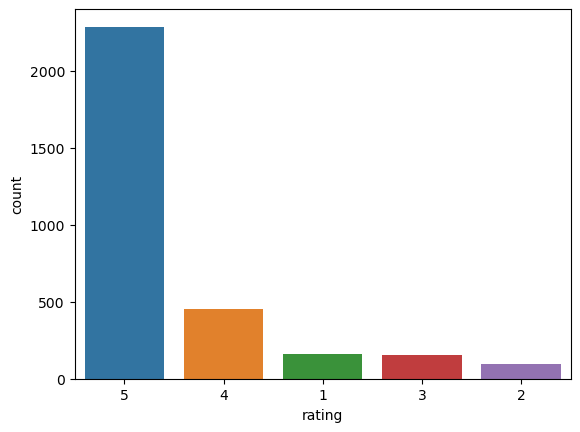

In [16]:
#Show distribution of labels in 'rating' variable (%)

sns.countplot(x = 'rating', data = df_alexa, order = df_alexa['rating'].value_counts().index)

Distribution shows that the largest amount of feedback has 5-star rating.

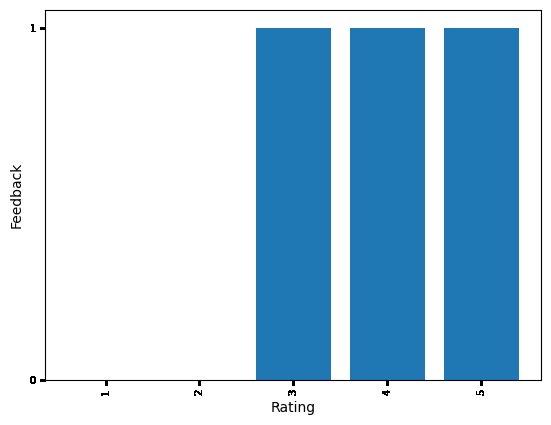

In [18]:
#Check which rating numbers refers to positive feedback

plt.bar(df_alexa['rating'], df_alexa['feedback'])
plt.xticks(df_alexa['rating'],rotation = 90, fontsize = 7)
plt.yticks(df_alexa['feedback'], fontsize = 7)
plt.xlabel('Rating')
plt.ylabel('Feedback')
plt.show()

In [19]:
df_alexa['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

In [20]:
df_alexa['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

Distribution of labels in variables 'rating' and 'feedback' shows that reviews with rating 1 and 2 are negative, while the reviews with rating from 3 to 5 are positive.

In [21]:
#Show number of labels in each variable

for variable in df_alexa:
    print(variable, ' - number of labels: ', df_alexa[variable].nunique())
print()    
print('Total number of labels: ', len(df_alexa))

rating  - number of labels:  5
date  - number of labels:  77
variation  - number of labels:  16
verified_reviews  - number of labels:  2300
feedback  - number of labels:  2

Total number of labels:  3149


In [22]:
#Check correlation between 'Feedback' and 'Date'

count_map = df_alexa['date'].value_counts().to_dict()
df_alexa['date'] = df_alexa['date'].map(count_map)

print('Correlation coefficient between "feedback" and "date": {:.2}'.format(df_alexa['feedback'].corr(df_alexa['date'])))

Correlation coefficient between "feedback" and "date": 0.083


In [23]:
#Check correlation between 'Feedback' and 'Variation'

count_map = df_alexa['variation'].value_counts().to_dict()
df_alexa['variation'] = df_alexa['variation'].map(count_map)

print('Correlation coefficient between "feedback" and "date": {:.2}'.format(df_alexa['feedback'].corr(df_alexa['variation'])))

Correlation coefficient between "feedback" and "date": 0.055


<Axes: >

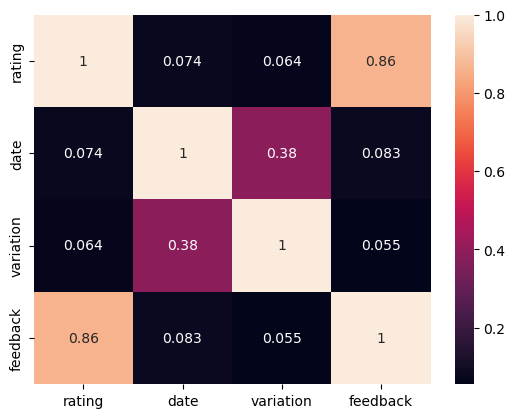

In [24]:
#Approve correlation coeffitients with heatmap

df_for_heatmap = df_alexa.drop(['verified_reviews'], axis = 1)
corr = df_for_heatmap.corr()

sns.heatmap(
    corr,
    annot = True,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

Correlation coefficient of the following variables with dependent variable is less than 0.1, so they can be taken out from dataset.

In [25]:
df_alexa = df_alexa.drop(['date', 'variation'], axis = 1)
df_alexa.head(10)

,rating,verified_reviews,feedback
0,5,Love my Echo!,1
1,5,Loved it!,1
2,4,"Sometimes while playing a game, you can answer...",1
3,5,I have had a lot of fun with this thing. My 4 ...,1
4,5,Music,1
5,5,I received the echo as a gift. I needed anothe...,1
6,3,"Without having a cellphone, I cannot use many ...",1
7,5,I think this is the 5th one I've purchased. I'...,1
8,5,looks great,1
9,5,Love it! I’ve listened to songs I haven’t hear...,1


<center><h2> 3. Data preprocessing </h2><center>

In [26]:
#Implement CountVectorizer

vectorizer = CountVectorizer()
alexa_countvectorizer = vectorizer.fit_transform(df_alexa['verified_reviews'])

In [27]:
alexa_countvectorizer.shape

(3149, 4044)

In [28]:
#Drop 'verified_reviews'

df_alexa.drop(['verified_reviews'], axis = 1, inplace = True)

In [29]:
reviews = pd.DataFrame(alexa_countvectorizer.toarray())

reviews.shape

(3149, 4044)

In [30]:
df_alexa.shape

(3149, 2)

In [31]:
df_alexa = pd.concat([df_alexa, reviews], axis = 1)

df_alexa

,rating,feedback,0,1,2,3,4,5,6,7,...,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043
0,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3144,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3145,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Redifine independent variables

X =  df_alexa.drop(['feedback','rating'], axis = 1)

X

,0,1,2,3,4,5,6,7,8,9,...,4034,4035,4036,4037,4038,4039,4040,4041,4042,4043
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Redifine dependent variable

y = df_alexa['feedback']

In [34]:
#Divide dataset on train & test parts

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,
    random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2204, 4044), (945, 4044), (2204,), (945,))

In [35]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

<center><h2> 4. Model Training </h2><center>

<h3> Random Forest Classifier </h3>

In [33]:
randomforest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state=0)
randomforest_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'criterion' : ['gini','entropy','log_loss'],
        'n_estimators':[10,50,100]
     }
]

grid_search = GridSearchCV(
    estimator = randomforest_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'criterion': 'gini', 'n_estimators': 50}


Accuracy: 93.23%


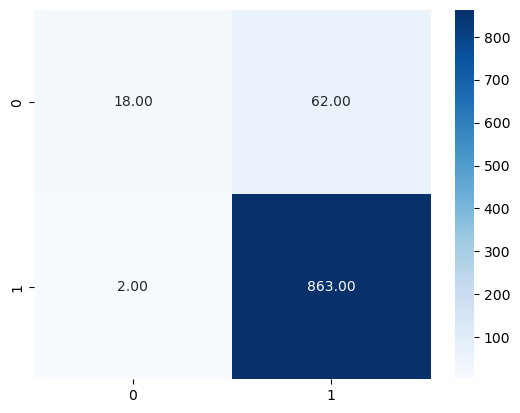

In [36]:
#Implement best parameters
randomforest_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'gini', random_state=0)
randomforest_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Random Forest Classifier')

y_pred_train = randomforest_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = randomforest_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [37]:
probs = randomforest_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 91.17%


In [38]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.23      0.36        80
           1       0.93      1.00      0.96       865

    accuracy                           0.93       945
   macro avg       0.92      0.61      0.66       945
weighted avg       0.93      0.93      0.91       945



<h3> Decision Tree Classifier </h3>

In [38]:
decisiontree_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
decisiontree_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'criterion' : ['gini','entropy','log_loss'],
        'splitter' : ['best','random']
     }
]

grid_search = GridSearchCV(
    estimator = decisiontree_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'criterion': 'gini', 'splitter': 'random'}


Accuracy: 92.28%


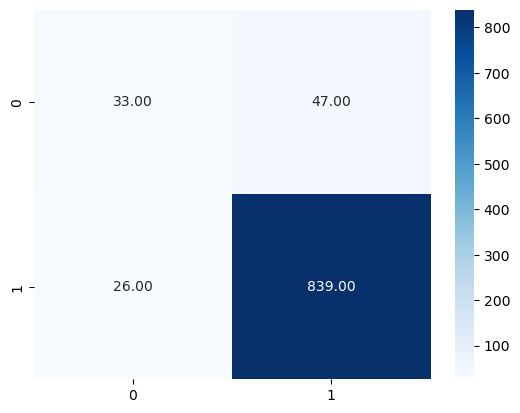

In [39]:
#Implement best parameters
decisiontree_classifier = DecisionTreeClassifier(criterion= 'gini', splitter = 'random', random_state=0)
decisiontree_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Decision Tree Classifier')

y_pred_train = decisiontree_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = decisiontree_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [40]:
probs = decisiontree_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 72.85%


In [41]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47        80
           1       0.95      0.97      0.96       865

    accuracy                           0.92       945
   macro avg       0.75      0.69      0.72       945
weighted avg       0.91      0.92      0.92       945



<h3> SVC </h3>

In [70]:
svc_classifier = SVC(kernel = 'linear', probability = True, random_state=0)
svc_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'C':[0.25, 0.5, 0.75, 1],
        'kernel':['linear', 'rbf']
     }
]

grid_search = GridSearchCV(
    estimator = svc_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'C': 0.5, 'kernel': 'linear'}


Accuracy: 92.38%


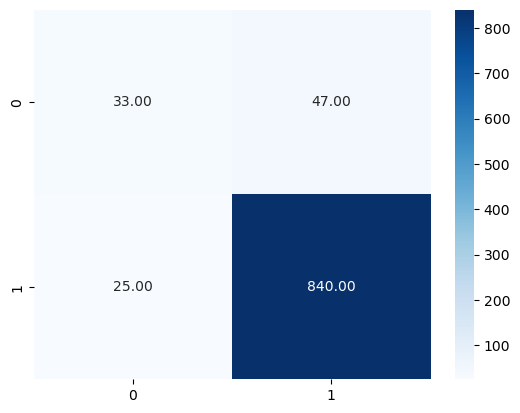

In [42]:
#Implement best parameters
svc_classifier = SVC(C = 0.5, kernel = 'linear', probability = True, random_state=0)
svc_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('SVC')

y_pred_train = svc_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = svc_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [43]:
probs = svc_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 84.47%


In [44]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48        80
           1       0.95      0.97      0.96       865

    accuracy                           0.92       945
   macro avg       0.76      0.69      0.72       945
weighted avg       0.92      0.92      0.92       945



<h3> KNN </h3>

In [46]:
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)

#GridSearch
parameters = [
    {
        'weights':['uniform','distance'],
        'algorithm':['ball_tree','kd_tree']
     }
]

grid_search = GridSearchCV(
    estimator = knn_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'algorithm': 'ball_tree', 'weights': 'distance'}


Accuracy: 92.91%


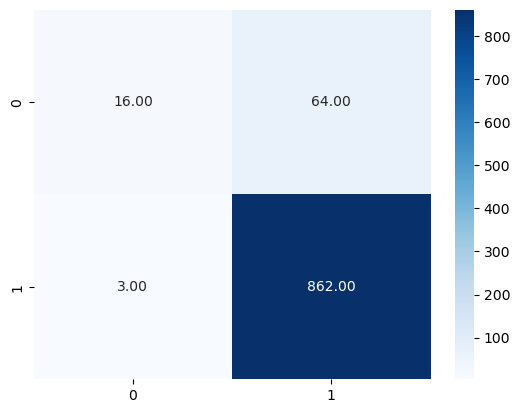

In [45]:
#Implement best parameters
knn_classifier = KNeighborsClassifier(weights = 'distance', algorithm = 'ball_tree', n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('KNN Classifier')

y_pred_train = knn_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = knn_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [46]:
probs = knn_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 68.66%


In [47]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.20      0.32        80
           1       0.93      1.00      0.96       865

    accuracy                           0.93       945
   macro avg       0.89      0.60      0.64       945
weighted avg       0.92      0.93      0.91       945



<h3> Logistic Regression </h3>

Accuracy: 93.12%


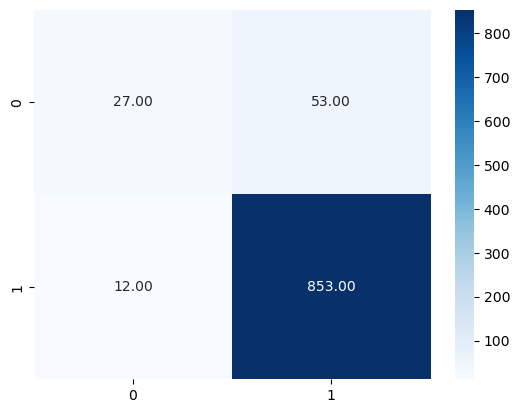

In [48]:
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Logistic Regression Classifier')

y_pred_train = lr_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = lr_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [49]:
probs = lr_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 86.54%


In [50]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.34      0.45        80
           1       0.94      0.99      0.96       865

    accuracy                           0.93       945
   macro avg       0.82      0.66      0.71       945
weighted avg       0.92      0.93      0.92       945



<h3> Naive Bayes </h3>

Accuracy: 64.87%


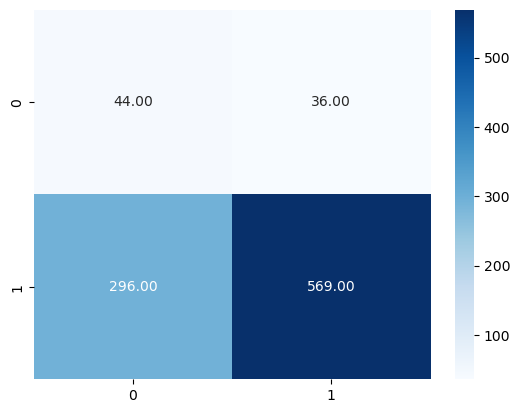

In [51]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Naive Bayese Classifier')

y_pred_train = nb_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = nb_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [52]:
probs = nb_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 60.39%


In [53]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.13      0.55      0.21        80
           1       0.94      0.66      0.77       865

    accuracy                           0.65       945
   macro avg       0.53      0.60      0.49       945
weighted avg       0.87      0.65      0.73       945



<h3> XG Boost </h3>

Accuracy: 94.29%


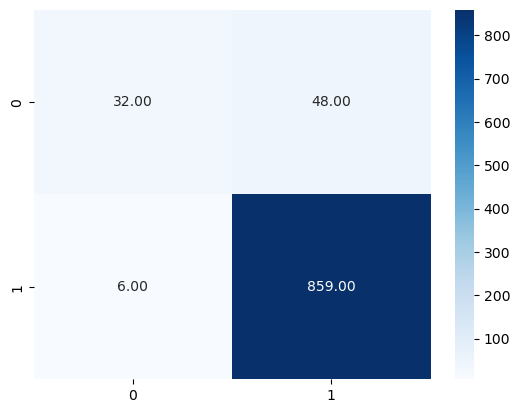

In [54]:
xgb_classifier = XGBClassifier(random_state = 0)
xgb_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('XG Boost Classifier')

y_pred_train = xgb_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = xgb_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [55]:
probs = xgb_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 88.63%


In [56]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.40      0.54        80
           1       0.95      0.99      0.97       865

    accuracy                           0.94       945
   macro avg       0.89      0.70      0.76       945
weighted avg       0.94      0.94      0.93       945



<h3> Ada Boost </h3>

Accuracy: 91.43%


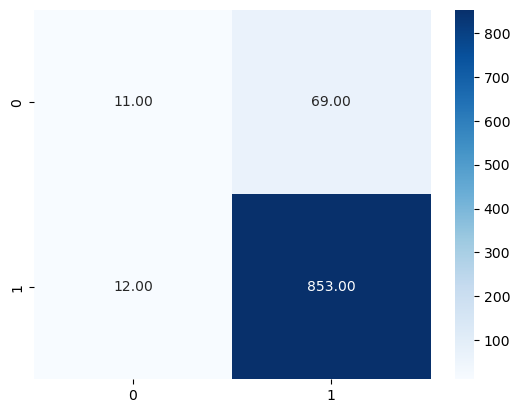

In [57]:
ab_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, algorithm='SAMME.R', random_state=1)
ab_classifier.fit(X_train, y_train)

#Evaluate the model

model_list.append('Ada Boost Classifier')

y_pred_train = ab_classifier.predict(X_train)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
train_accuracy_score_list.append(accuracy_score_train)

y_pred_test = ab_classifier.predict(X_test)
accuracy_score_test = accuracy_score(y_test, y_pred_test)
test_accuracy_score_list.append(accuracy_score_test)

cm = confusion_matrix(y_test, y_pred_test)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy: {:.2%}'.format(accuracy_score_test))

In [58]:
probs = ab_classifier.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC = {:.2%}'.format(auc))
roc_auc_list.append(auc)

Model ROC-AUC = 87.81%


In [59]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.48      0.14      0.21        80
           1       0.93      0.99      0.95       865

    accuracy                           0.91       945
   macro avg       0.70      0.56      0.58       945
weighted avg       0.89      0.91      0.89       945



<center><h2> RESULTS </h2><center>

In [60]:
results = pd.DataFrame({'model': model_list,
                       'train_accuracy_score': train_accuracy_score_list,
                       'test_accuracy_score': test_accuracy_score_list,
                       'roc-auc_score': roc_auc_list}
                       )

In [61]:
results.sort_values(by = 'roc-auc_score', ascending = False)

,model,train_accuracy_score,test_accuracy_score,roc-auc_score
0,Random Forest Classifier,0.994555,0.932275,0.911741
6,XG Boost Classifier,0.986388,0.942857,0.886329
7,Ada Boost Classifier,0.948276,0.914286,0.878114
4,Logistic Regression Classifier,0.984120,0.931217,0.865354
2,SVC,0.989564,0.923810,0.844704
1,Decision Tree Classifier,0.994555,0.922751,0.728512
3,KNN Classifier,0.994555,0.929101,0.686633
5,Naive Bayese Classifier,0.701906,0.648677,0.603902


(0.6, 1.02)

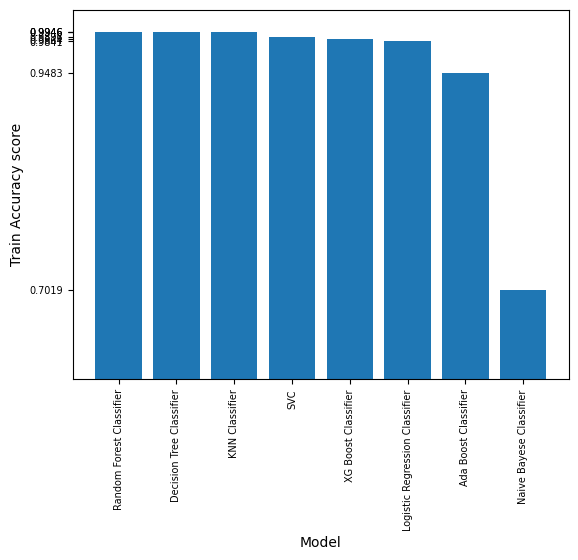

In [65]:
results_plot = results.sort_values('train_accuracy_score',ascending=False)
plt.bar(results_plot['model'], results_plot['train_accuracy_score'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['train_accuracy_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Train Accuracy score')
plt.ylim(0.60, 1.02)

(0.6, 0.96)

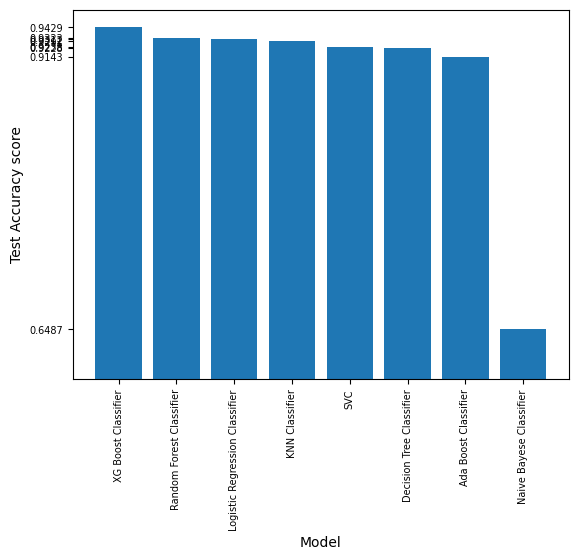

In [69]:
results_plot = results.sort_values('test_accuracy_score',ascending=False)
plt.bar(results_plot['model'], results_plot['test_accuracy_score'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['test_accuracy_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Test Accuracy score')
plt.ylim(0.60, 0.96)

(0.55, 0.92)

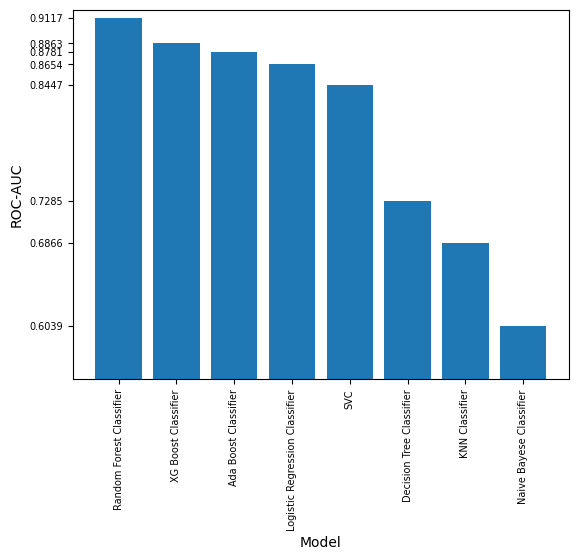

In [73]:
results_plot = results.sort_values('roc-auc_score',ascending=False)
plt.bar(results_plot['model'], results_plot['roc-auc_score'])
plt.xticks(results_plot['model'],rotation = 90, fontsize = 7)
plt.yticks(results_plot['roc-auc_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.ylim(0.55, 0.92)

According to the comparison of train/test accuracy score (difference is less than 3%) and ROC-AUC (above 87%) for test set <b> AdaBoost Classifier </b> was chosen as the best classification model.

In [69]:
testing_sample = ['Terrible', 'Awesome, my best buy']
testing_sample_countvectorizer = vectorizer.transform(testing_sample)
test_predict = ab_classifier.predict(testing_sample_countvectorizer)
test_predict

array([0, 1], dtype=int64)